In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten , InputLayer ,Input
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision ,Recall , Accuracy , F1Score
import tensorflow_datasets as tfds
import tensorflow as tf

2024-02-19 20:18:48.253648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 20:18:48.253713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 20:18:48.255222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised= True,
                                  shuffle_files= True,
                                  split=['train'])

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [4]:
dataset = dataset[0]

In [5]:
def split_dataset(dataset  , train_size , test_size ,val_size = 0):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(DATASET_SIZE*train_size))
  test_dataset = dataset.skip(int(DATASET_SIZE*train_size)).take(int(DATASET_SIZE*test_size))
  val_dataset = dataset.skip(int(DATASET_SIZE*train_size)).skip(int(DATASET_SIZE*test_size))
  return train_dataset, test_dataset ,val_dataset

In [6]:
lists = [10,10,3 ,4,5,6,8,9,0,14]
DATASET_SIZE = len(dataset)
TRAIN_RATIO =0.8
TEST_RATIO =0.1
VAL_RATIO =0.1

In [7]:
DATASET_SIZE

27558

In [8]:
train_dataset, test_dataset ,val_dataset = split_dataset(dataset  , TRAIN_RATIO , TEST_RATIO ,VAL_RATIO)

In [9]:
len(test_dataset)

2755

In [10]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
train_dataset.take(1).as_numpy_iterator()

In [12]:
list_train = list(train_dataset.take(1).as_numpy_iterator())

In [13]:
list_train

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  0)]

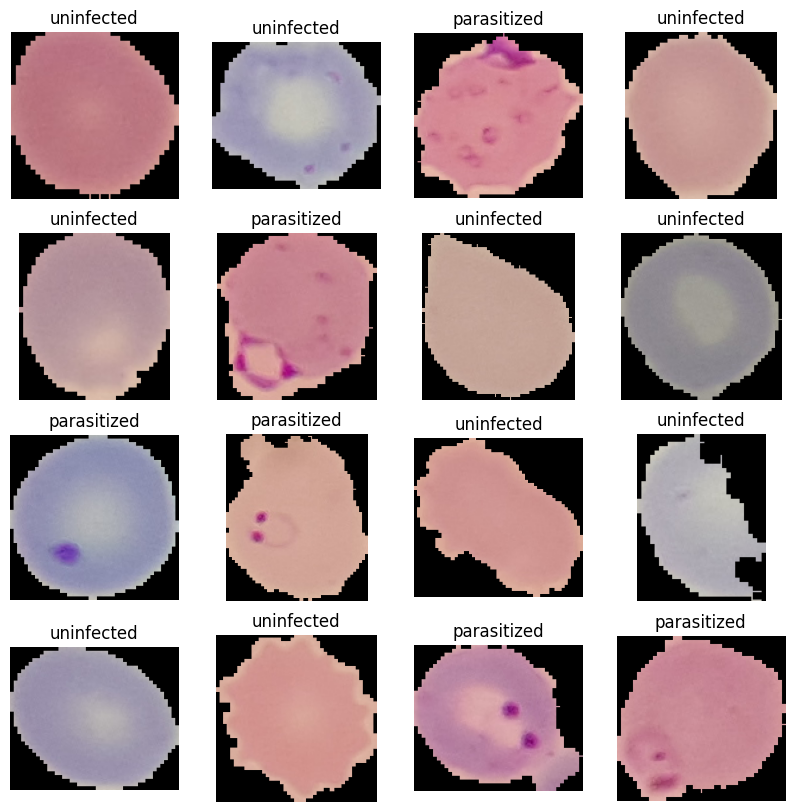

In [14]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [15]:
IMAGE_SIZE = 224

In [16]:
def image_resize_normalize (image , label ) :
  image = tf.image.resize(image , (IMAGE_SIZE ,IMAGE_SIZE)) /255
  return image , label

In [17]:
train_dataset =  train_dataset.map(image_resize_normalize)
test_dataset =  test_dataset.map(image_resize_normalize)
val_dataset = val_dataset.map(image_resize_normalize)

In [18]:
for data in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(124, 127, 3), dtype=uint8) tf.Tensor(0, shape=(), dtype=int64)


In [19]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
val_dataset = val_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
test_dataset = test_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
input_tensor = Input(shape = (IMAGE_SIZE , IMAGE_SIZE , 3)) 

x = Conv2D(filters = 6 ,kernel_size= 6 ,padding ='valid' , activation = 'relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2) , strides=2)(x)

x = Conv2D(filters = 16 ,kernel_size= 3 ,padding ='valid' , activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2) , strides=2)(x)

x = Flatten()(x)

x = Dense(100 , activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(10 , activation = 'relu')(x)
x = BatchNormalization()(x)

output = Dense(1 , activation = 'sigmoid')(x)


model = Model(inputs = input_tensor , outputs= output )



In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 219, 219, 6)       654       
                                                                 
 batch_normalization (Batch  (None, 219, 219, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 107, 107, 16)      64    

In [24]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

def F1Score(y_true, y_pred, precision=precision, recall=recall):
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_result = precision.result()
    recall_result = recall.result()
    return (2 * precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon())

In [25]:
 metrics=['accuracy',
          
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                  F1Score,
          
                    
]

In [26]:
model.compile(optimizer = Adam(learning_rate= 0.01),
loss = BinaryCrossentropy(),
              metrics = metrics,
              )

In [27]:
history = model.fit(train_dataset , validation_data=val_dataset ,epochs=5 , verbose = 1)

Epoch 1/5


I0000 00:00:1708373938.500604    7195 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


689/689 [==============================] - 31s 37ms/step - loss: 0.5001 - accuracy: 0.7444 - precision_1: 0.7450 - recall_1: 0.7434 - F1Score: 0.6598 - val_loss: 0.3939 - val_accuracy: 0.8749 - val_precision_1: 0.8842 - val_recall_1: 0.8603 - val_F1Score: 0.7519
Epoch 2/5
689/689 [==============================] - 25s 36ms/step - loss: 0.2344 - accuracy: 0.9178 - precision_1: 0.9098 - recall_1: 0.9275 - F1Score: 0.8034 - val_loss: 0.6389 - val_accuracy: 0.8807 - val_precision_1: 0.8689 - val_recall_1: 0.8938 - val_F1Score: 0.8356
Epoch 3/5
689/689 [==============================] - 25s 36ms/step - loss: 0.1922 - accuracy: 0.9352 - precision_1: 0.9302 - recall_1: 0.9409 - F1Score: 0.8538 - val_loss: 0.2394 - val_accuracy: 0.9329 - val_precision_1: 0.9015 - val_recall_1: 0.9698 - val_F1Score: 0.8685
Epoch 4/5
689/689 [==============================] - 25s 36ms/step - loss: 0.1784 - accuracy: 0.9406 - precision_1: 0.9362 - recall_1: 0.9456 - F1Score: 0.8785 - val_loss: 0.2708 - val_accura

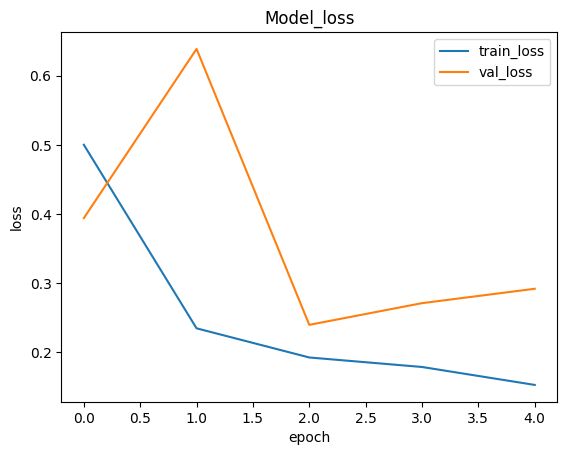

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

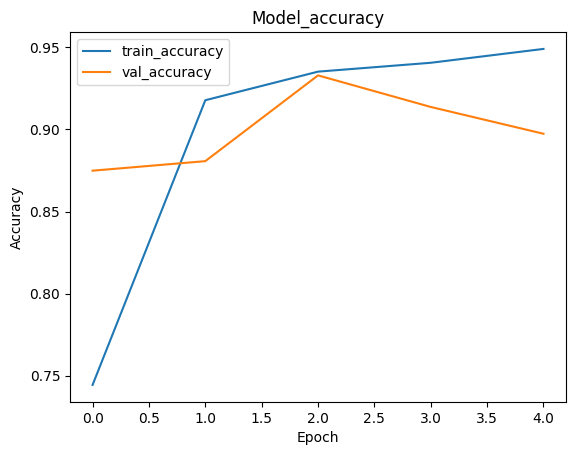

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [30]:
model.evaluate(test_dataset)

87/87 [==============================] - 6s 18ms/step - loss: 0.2743 - accuracy: 0.9067 - precision_1: 0.9506 - recall_1: 0.8595 - F1Score: 0.8983


[0.27431759238243103,
 0.9067150354385376,
 0.9505975842475891,
 0.859510064125061,
 0.8982945680618286]

In [34]:
def paraside_or_not(x):
  if(x < 0.5):
    return str('parasitized')
  else:
    return str('Uninfected')

1/1 [==============================] - 0s 34ms/step


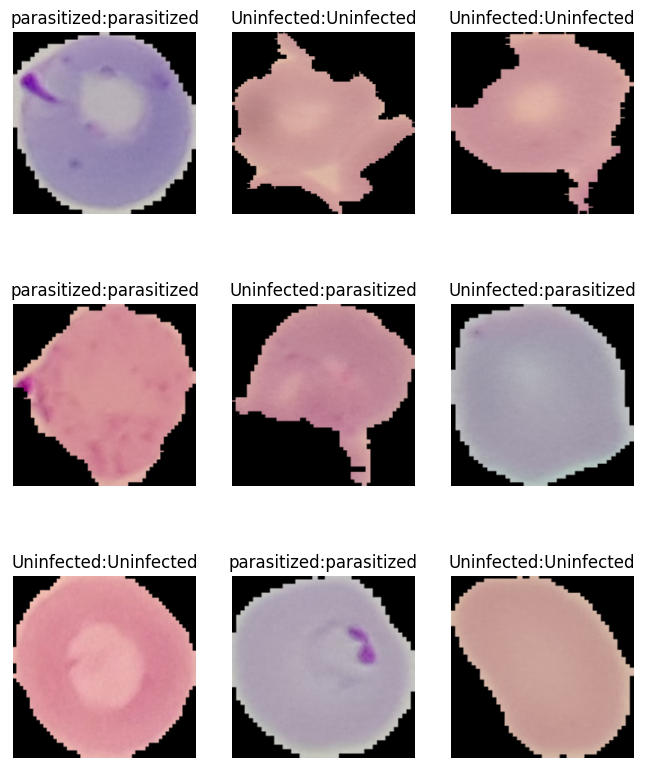

In [35]:
plt.figure(figsize=(8,10))
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(paraside_or_not(label.numpy()[0])) + ":" +str(paraside_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [36]:
y_pred = model.predict(test_dataset)

87/87 [==============================] - 6s 17ms/step


In [37]:
y_test = list(test_dataset.take(1).as_numpy_iterator())

In [ ]:
y_test